In [518]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import skew, kurtosis
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy.stats import norm

## 1. Data preparation

Read original dataset

In [519]:
df = pd.read_csv('ukr_data_from_2017.csv')
df = df.drop(['Unnamed: 0'], axis=1)
df['Місяць'] = pd.to_datetime(df['Місяць'])
df.head()

,Місяць,Рис,Хліб пшеничний з борошна вищого ґатунку,Хліб пшеничний з борошна першого ґатунку,"Хліб житній, житньо-пшеничний",Батон,Макаронні вироби з м’яких сортів пшениці,Борошно пшеничне,Крупи манні,Крупи гречані,...,Жарознижувальні та знеболювальні препарати вітчизняні,Жарознижувальні та знеболювальні препарати імпортні,Стоматологічні послуги,Бензин А-92,Бензин А-95,Дизельне пальне,Газ скраплений для автомобілів,Проїзд у міському транспорті,Дошкільна освіта,Послуги у сфері страхування особистого транспорту
0,1991-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1991-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1991-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1991-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1991-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Display graphs of all products in original dataset

In [520]:
def plot_all_var(df, ls: list):
    for column in ls:
        plt.figure(figsize=(6, 2))
        plt.plot(df['Місяць'], df[column])
        plt.title(column)
        plt.xlabel('date')
        plt.ylabel('value')
        plt.grid(True)

# plot_all_var(df, list(df.columns)[1:])
# list(df.columns)[1:]

In report we described how we form basket of goods and now we form dataset, which contains only products requred for basket

In [521]:
bread = ["Хліб пшеничний з борошна вищого ґатунку", "Хліб пшеничний з борошна першого ґатунку", "Хліб житній, житньо-пшеничний", "Батон"]
cereals = ["Рис", "Крупи манні", "Крупи гречані", "Крупи ячні", "Пшоно"]

meat = ["Яловичина", "Свинина", "Птиця (тушки курячі)", "Філе куряче"]
pasta = ["Макаронні вироби з м’яких сортів пшениці"]
kybasa = ["Ковбаси варені першого ґатунку", "Сало"]
fish = ["Риба морожена"]
milk = ["Молоко пастеризоване жирністю до 2,6% включно"]

dairy = ["Сметана жирністю до 15% включно", "Масло вершкове"]
cheese = ["Сири м’які жирні"]
eggs = ["Яйця"]
sun_oli = ["Олія соняшникова"]
fruits = ["Яблука"]
vege = ["Капуста білокачанна", "Цибуля ріпчаста", "Буряк", "Морква"]
potato = ["Картопля"]
sugar = ["Цукор"]


Design a new dataset with grouped products

In [522]:
product_df = df.copy()
product_df = product_df.drop(list(df.columns)[1:], axis=1)
product_df.shape

(408, 1)

In [523]:
product_df['Хліб'] = round(df[bread].mean(axis=1), 2)
product_df['Крупи'] = round(df[cereals].mean(axis=1), 2)
product_df['Мʼясо свійських тварин та птиці'] = round(df[meat].mean(axis=1), 2)
product_df['Макарони'] = round(df[pasta].mean(axis=1), 2)
product_df['Картопля'] = df['Картопля']
product_df['Ковбасні вироби'] = round(df[kybasa].mean(axis=1), 2)
product_df['Молоко пастеризоване жирністю до 2,6% включно'] = df['Молоко пастеризоване жирністю до 2,6% включно']
product_df['Молочні продукти'] = round(df[dairy].mean(axis=1), 2)
product_df['Овочі'] = round(df[vege].mean(axis=1), 2)
product_df['Олія соняшникова'] = df['Олія соняшникова']
product_df['Риба'] = df["Риба морожена"]
product_df['Сир'] = df["Сири м’які жирні"]
product_df['Цукор'] = df['Цукор']
product_df['Яблука'] = df['Яблука']
product_df['Яйця'] = df['Яйця']
product_df.head()

product_df = product_df.drop(index=range(0, 312), errors='ignore')
product_df.to_csv('ukr_product_basket.csv')
product_df.head()

,Місяць,Хліб,Крупи,Мʼясо свійських тварин та птиці,Макарони,Картопля,Ковбасні вироби,"Молоко пастеризоване жирністю до 2,6% включно",Молочні продукти,Овочі,Олія соняшникова,Риба,Сир,Цукор,Яблука,Яйця
312,2017-01-01,12.07,16.22,70.34,13.76,5.58,55.80,17.93,35.96,4.38,32.97,65.43,75.77,17.09,12.15,22.02
313,2017-02-01,12.48,16.39,72.36,13.89,6.11,56.44,18.58,37.18,4.53,33.30,65.93,77.69,17.61,12.43,18.33
314,2017-03-01,12.74,16.49,73.33,14.02,6.25,56.88,19.04,37.99,4.46,33.44,66.21,79.20,18.27,12.67,16.97
315,2017-04-01,12.85,16.41,75.25,14.12,6.71,57.70,19.26,38.18,5.63,33.74,66.61,79.34,18.48,13.63,13.90
316,2017-05-01,12.95,16.14,77.62,14.20,8.36,58.02,19.35,38.34,9.12,33.74,67.21,78.85,18.54,17.46,12.06


In [524]:
fff = pd.read_csv('ukr_product_basket.csv')
fff = fff.drop(["Unnamed: 0"], axis=1)
fff.to_csv("product_basket.csv")
fff.head()

,Місяць,Хліб,Крупи,Мʼясо свійських тварин та птиці,Макарони,Картопля,Ковбасні вироби,"Молоко пастеризоване жирністю до 2,6% включно",Молочні продукти,Овочі,Олія соняшникова,Риба,Сир,Цукор,Яблука,Яйця
0,2017-01-01,12.07,16.22,70.34,13.76,5.58,55.80,17.93,35.96,4.38,32.97,65.43,75.77,17.09,12.15,22.02
1,2017-02-01,12.48,16.39,72.36,13.89,6.11,56.44,18.58,37.18,4.53,33.30,65.93,77.69,17.61,12.43,18.33
2,2017-03-01,12.74,16.49,73.33,14.02,6.25,56.88,19.04,37.99,4.46,33.44,66.21,79.20,18.27,12.67,16.97
3,2017-04-01,12.85,16.41,75.25,14.12,6.71,57.70,19.26,38.18,5.63,33.74,66.61,79.34,18.48,13.63,13.90
4,2017-05-01,12.95,16.14,77.62,14.20,8.36,58.02,19.35,38.34,9.12,33.74,67.21,78.85,18.54,17.46,12.06


Design basket column, based on prices from previous dataset and consamption weights (calculate price of basket per month per one adult person)

In [525]:
prod_n_basket = pd.read_csv("product_basket.csv")
product_weights = {
    'Хліб': 0.277 * 30,
    'Макарони': 0.011 * 30,
    'Картопля': 0.260 * 30,
    'Овочі': 0.110 * 30,
    'Яблука': 0.064 * 30,
    # 8 t.s: small tea spoon 5g, big - 8, average 6.5 -> 6.5 * 8 = 52 г
    'Цукор': 0.052 * 30,
    'Ковбасні вироби': 0.03 * 30,
    'Мʼясо свійських тварин та птиці': 0.116 * 30,
    'Олія соняшникова': 0.027 * 30,
    'Риба': 0.030 * 30,
    'Молоко пастеризоване жирністю до 2,6% включно': 0.342 * 30,
    'Молочні продукти': 0.014 * 30,
    'Сир': 0.036 * 30,
    # egg prices are indicated per dozen, then /10 -> this will be the cost of one egg and multiply by 0.6, because this is the number of eggs per day
    'Яйця': 0.06 * 30, 
    'Крупи': 0.1 * 30
}

In [526]:
df_basket = prod_n_basket.copy()
df_basket['basket_price'] = 0
for product, weight in product_weights.items():
    df_basket['basket_price'] += df_basket[product] * weight
    
df_basket['basket_price'] = round(df_basket['basket_price'], 2)
df_basket = df_basket.drop(["Unnamed: 0"], axis=1)
df_basket.to_csv("product_n_basket.csv")

Load salary dataset 

In [527]:
salary = pd.read_csv("salary_time_2018.csv")
salary.head(100)

,Month,Salary
0,2017-M01,5378.61
1,2017-M02,5590.26
2,2017-M03,5887.70
3,2017-M04,5843.43
4,2017-M05,6173.33
...,...,...
91,2024-M08,17001.36
92,2024-M09,18020.86
93,2024-M10,18704.98
94,2024-M11,18823.31


In [528]:
df = df_basket

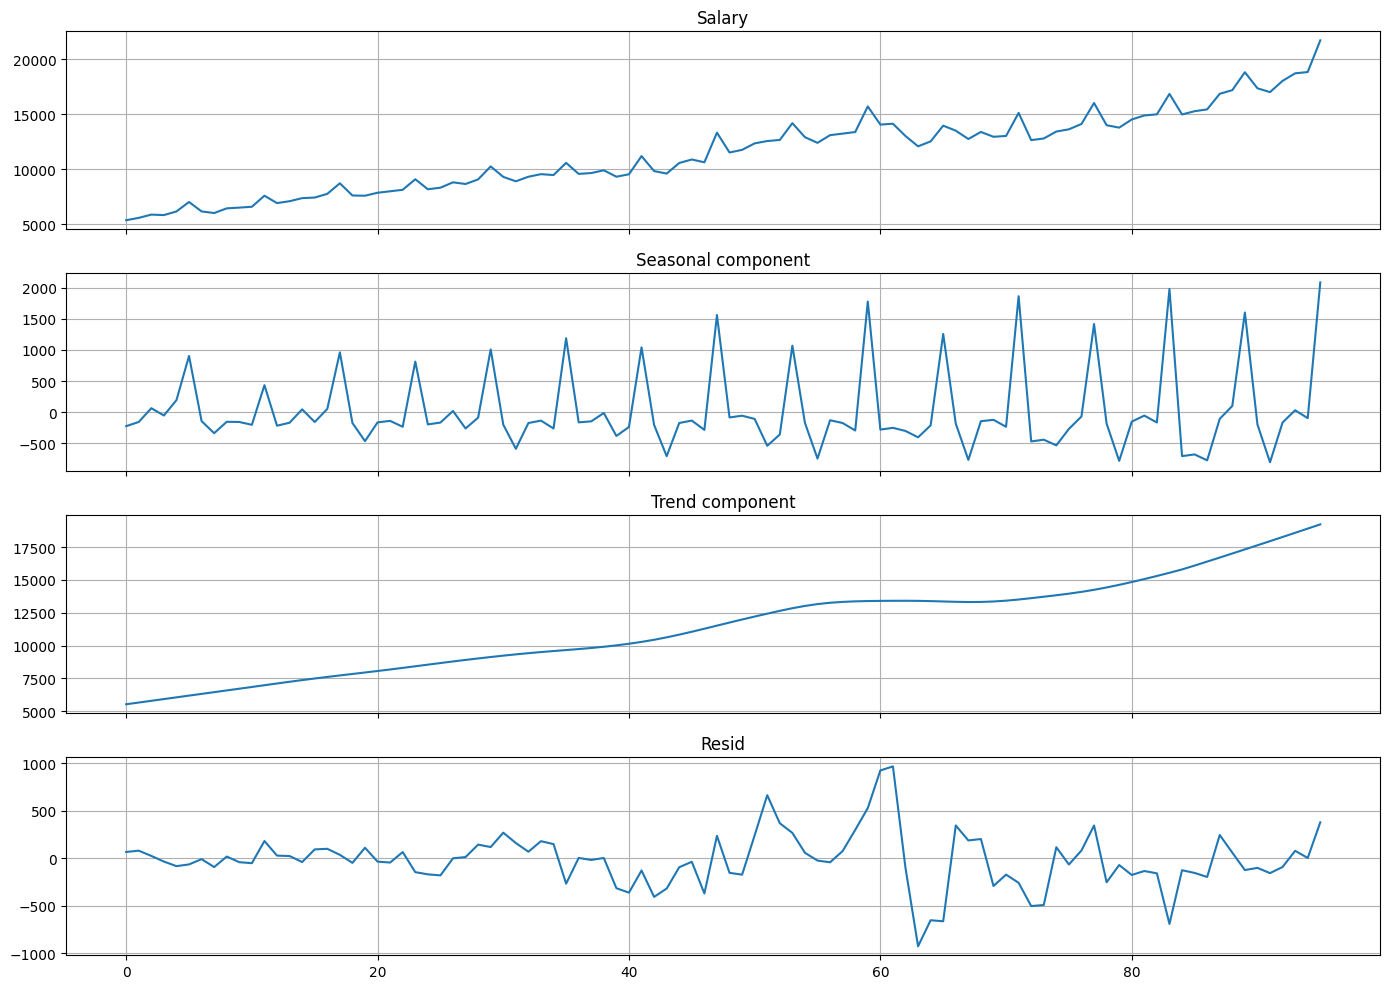

In [529]:
stl = STL(salary['Salary'], period=12)
result = stl.fit()

salary['seasonal'] = result.seasonal
salary['trend'] = result.trend
salary['resid'] = result.resid

fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
components = ['Salary', 'seasonal', 'trend', 'resid']
titles = ['Salary', 'Seasonal component', 'Trend component', 'Resid']

for ax, comp, title in zip(axes, components, titles):
    ax.plot(salary.index, salary[comp], label=title)
    ax.set_title(title)
    ax.grid(True)

plt.tight_layout()
plt.show()

In [530]:
df["salary"] = salary['resid']

In [531]:
unemployment = pd.read_csv("unemployment.csv")

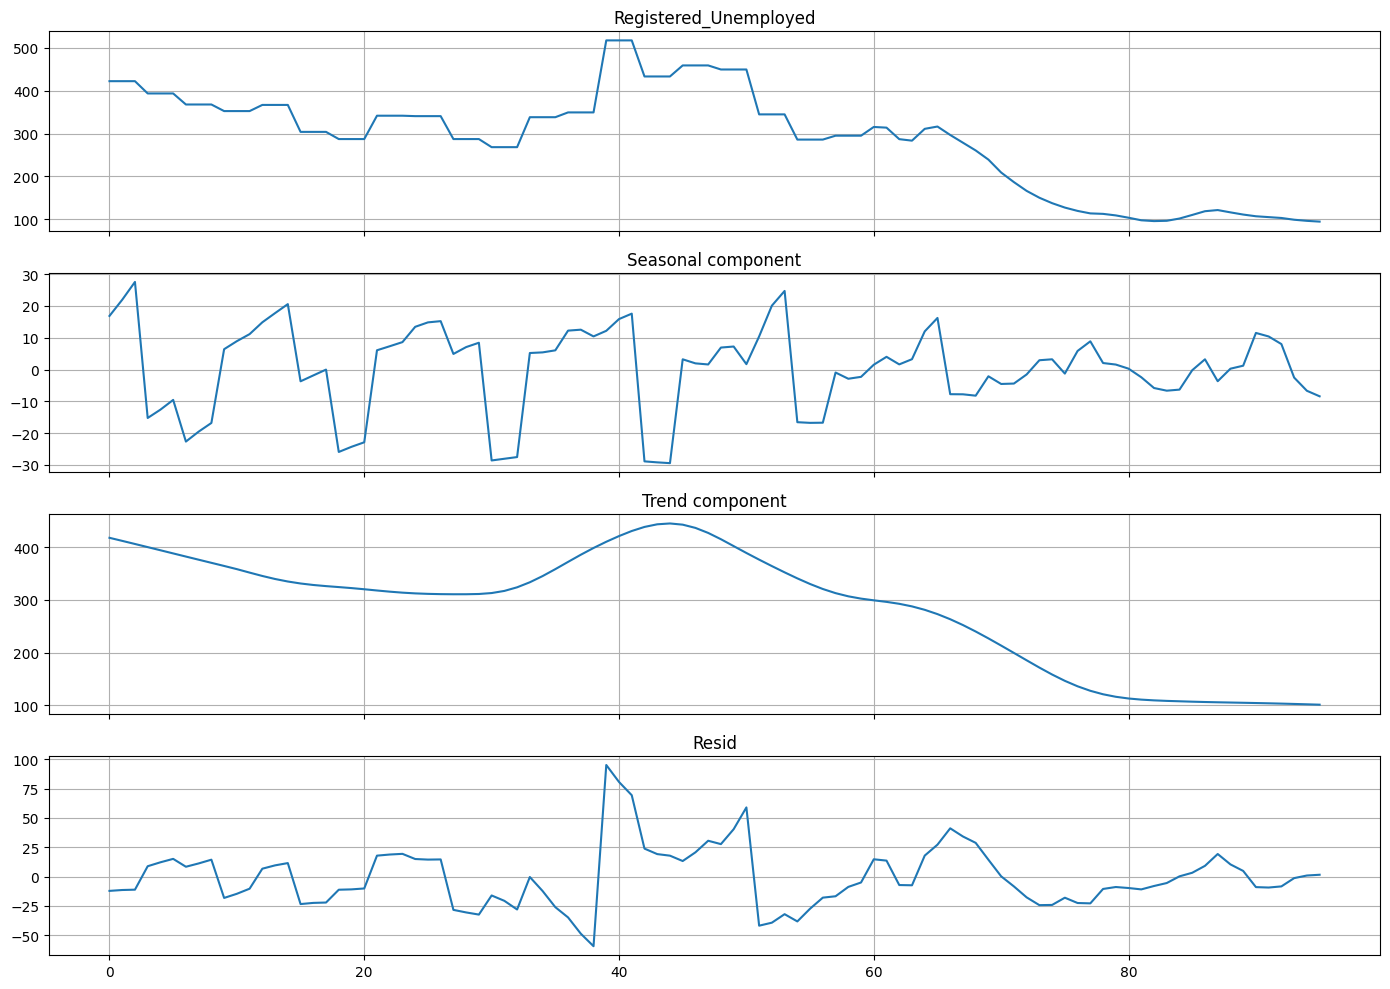

In [532]:
stl = STL(unemployment['Registered_Unemployed'], period=12)
result = stl.fit()

unemployment['seasonal'] = result.seasonal
unemployment['trend'] = result.trend
unemployment['resid'] = result.resid

fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
components = ['Registered_Unemployed', 'seasonal', 'trend', 'resid']
titles = ['Registered_Unemployed', 'Seasonal component', 'Trend component', 'Resid']

for ax, comp, title in zip(axes, components, titles):
    ax.plot(unemployment.index, unemployment[comp], label=title)
    ax.set_title(title)
    ax.grid(True)

plt.tight_layout()
plt.show()

In [533]:
df["unemployed"] = unemployment['resid']

In [534]:
taxes = pd.read_csv("nadkhodzhennia_podatkiv_2017_2024.csv")

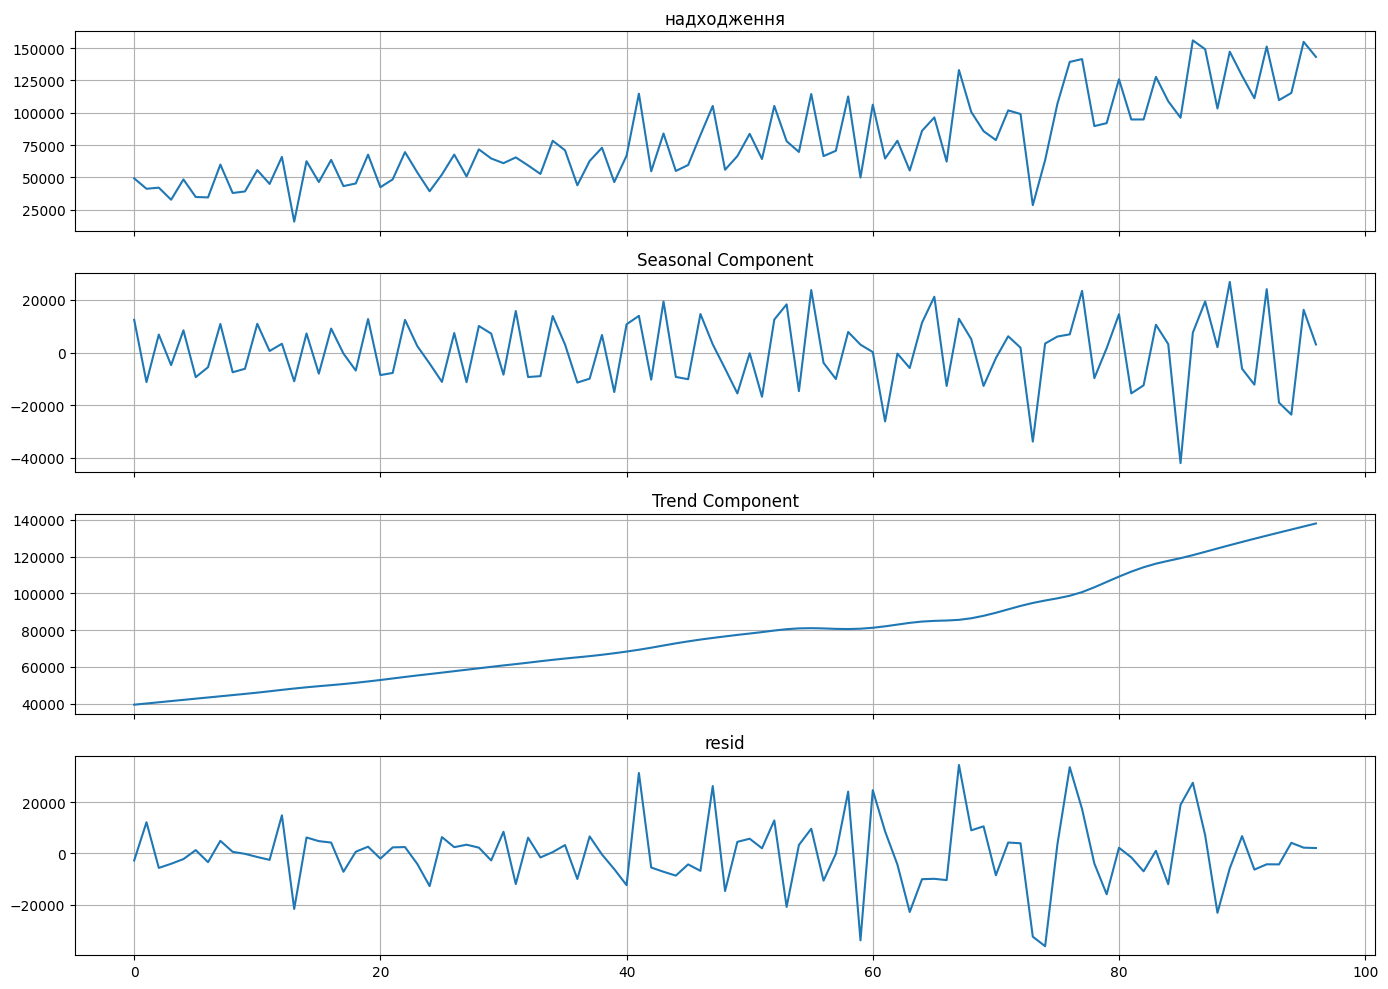

In [535]:
stl = STL(taxes['надходження'], period=12)
result = stl.fit()

taxes['seasonal'] = result.seasonal
taxes['trend'] = result.trend
taxes['resid'] = result.resid

fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
components = ['надходження', 'seasonal', 'trend', 'resid']
titles = ['надходження', 'Seasonal Component', 'Trend Component', 'resid']

for ax, comp, title in zip(axes, components, titles):
    ax.plot(taxes.index, taxes[comp], label=title)
    ax.set_title(title)
    ax.grid(True)

plt.tight_layout()
plt.show()

In [536]:
df["надходження"] = taxes['resid']

In [537]:
df["Місяць"] = df["Місяць"].str.replace(r"(\d{4})-M(\d{2})", r"\1-\2", regex=True)
df["Місяць"] = pd.to_datetime(df["Місяць"])

CPI

In [538]:
base_price = df.loc[df["Місяць"] == "2017-01-01", "basket_price"].values[0]
df['CPI'] = (df['basket_price'] / base_price) * 100

In [539]:
df['CPI']

0     100.000000
1     102.168086
2     103.543528
3     105.134012
4     109.092042
         ...    
91    251.422190
92    255.893414
93    267.918138
94    282.184708
95    288.897777
Name: CPI, Length: 96, dtype: float64

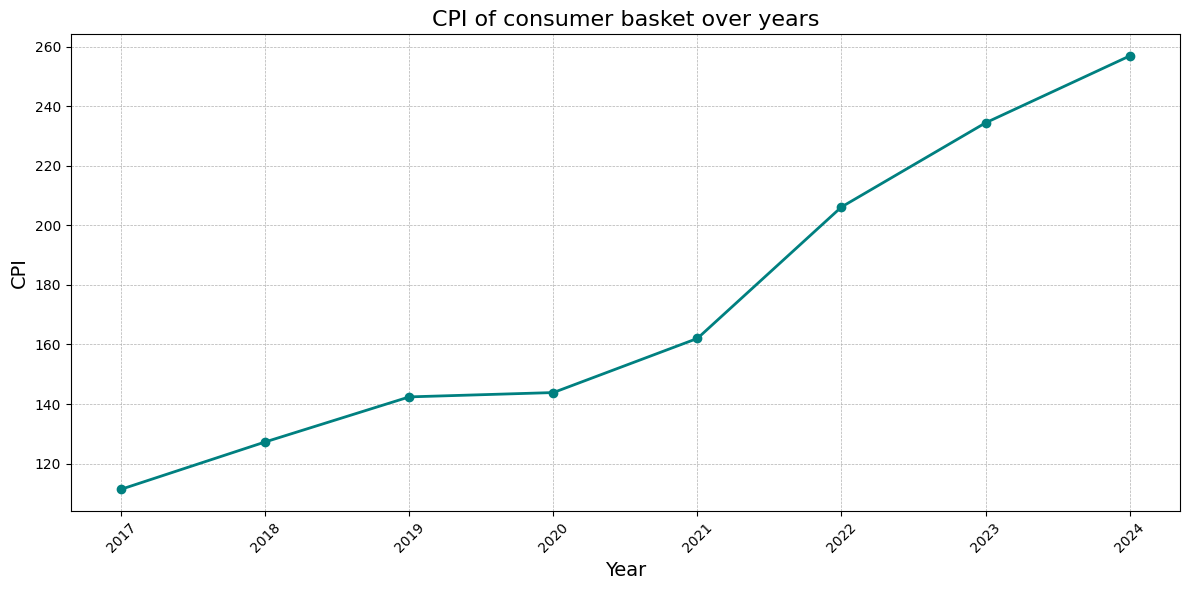

In [540]:
df['Year'] = pd.to_datetime(df['Місяць']).dt.year
yearly_cpi = df.groupby("Year")["CPI"].mean()

plt.figure(figsize=(12, 6))
plt.plot(yearly_cpi.index, yearly_cpi.values, marker="o", linewidth=2, color="teal")
plt.title("CPI of consumer basket over years", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("CPI", fontsize=14)
plt.xticks(yearly_cpi.index, rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

Skewness: 0.528108867038939
Kurtosis: -1.0800138150822172


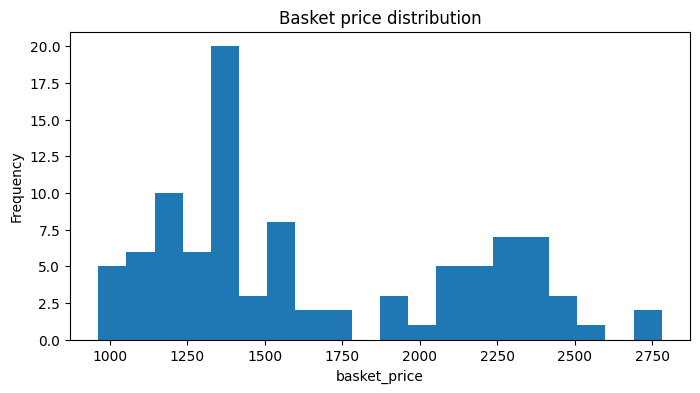

In [541]:
x = df["basket_price"]
print("Skewness:", skew(x))
print("Kurtosis:", kurtosis(x))

plt.figure(figsize=(8,4))
plt.hist(df["basket_price"], bins=20)
plt.title("Basket price distribution")
plt.xlabel("basket_price")
plt.ylabel("Frequency")
plt.show()

## 2. Construct models

$$
\text{CPI\_price} = \beta_0 + \beta_1 \cdot \text{covid} + \beta_2 \cdot \text{war} + \beta_3 \cdot \text{time} + \sum \beta_{\text{month}_i} \cdot D_i + \epsilon
$$

In [542]:
df["covid"] = ((df["Місяць"] >= "2020-03-01") & (df["Місяць"] <= "2021-03-01")).astype(int)
df["war"] = ((df["Місяць"] >= "2022-03-01") & (df["Місяць"] <= "2023-03-01")).astype(int)
df["time"] = np.arange(len(df))
df["month"] = df["Місяць"].dt.month.astype("category")

X = pd.get_dummies(df[["covid", "war", "time", "month"]], drop_first=True).astype(float)
y = df["CPI"]
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    CPI   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     122.4
Date:                Wed, 30 Apr 2025   Prob (F-statistic):           2.46e-48
Time:                        19:22:48   Log-Likelihood:                -363.68
No. Observations:                  96   AIC:                             757.4
Df Residuals:                      81   BIC:                             795.8
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         92.9056      4.527     20.521      0.0

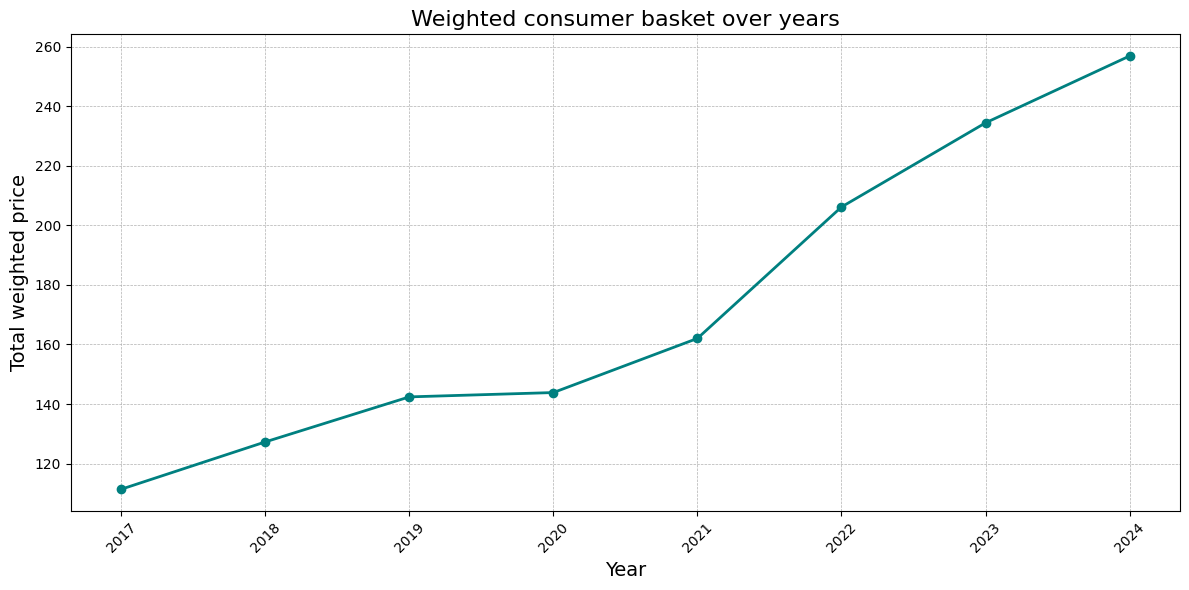

In [543]:
yearly_sum = df.groupby("Year")["basket_price"].sum()

plt.figure(figsize=(12, 6))
plt.plot(yearly_cpi.index, yearly_cpi.values, marker="o", linewidth=2, color="teal")
plt.title("Weighted consumer basket over years", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Total weighted price", fontsize=14)
plt.xticks(yearly_cpi.index, rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

$$
\text{basket\_price} = \beta_0 + \beta_1 \cdot \text{covid} + \beta_2 \cdot \text{war} + \beta_3 \cdot \text{time} + \sum \beta_{\text{month}_i} \cdot D_i + \epsilon
$$


time - trend(Steady monthly growth of ≈ UAH 375)

month(base - january) - Seasonal effects are not statistically significant

In [544]:
X = pd.get_dummies(df[["covid", "war", "time", "month"]], drop_first=True).astype(float)
y = df["basket_price"]
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:           basket_price   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     122.4
Date:                Wed, 30 Apr 2025   Prob (F-statistic):           2.46e-48
Time:                        19:22:49   Log-Likelihood:                -581.07
No. Observations:                  96   AIC:                             1192.
Df Residuals:                      81   BIC:                             1231.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        894.3088     43.581     20.521      0.0

In [545]:
X = pd.get_dummies(df[["covid", "war", "salary", "time", "month"]], drop_first=True).astype(float)
y = df["CPI"]
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                    CPI   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     119.2
Date:                Wed, 30 Apr 2025   Prob (F-statistic):           3.43e-48
Time:                        19:22:49   Log-Likelihood:                -361.15
No. Observations:                  96   AIC:                             754.3
Df Residuals:                      80   BIC:                             795.3
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         93.5306      4.447     21.031      0.0

In [546]:
df[["time", "salary"]].corr()


,time,salary
time,1.000000,-0.088511
salary,-0.088511,1.000000


In [547]:
X = pd.get_dummies(df[["covid", "war", "salary", "unemployed", "надходження", "time", "month"]], drop_first=True).astype(float)
y = df["CPI"]
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                    CPI   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     113.7
Date:                Wed, 30 Apr 2025   Prob (F-statistic):           9.05e-48
Time:                        19:22:49   Log-Likelihood:                -356.42
No. Observations:                  96   AIC:                             748.8
Df Residuals:                      78   BIC:                             795.0
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          94.4696      4.300     21.968      

In [548]:
df = pd.get_dummies(df, columns=["month"], prefix="month", drop_first=True)
X_vars = ["covid", "war", "salary", "unemployed", "time"] + \
         [col for col in df.columns if col.startswith("month_")]
correlation_matrix = df[X_vars].corr()
correlation_matrix




,covid,war,salary,unemployed,time,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
covid,1.000000,-0.156627,-0.175939,0.523308,-0.049985,-0.009179,0.100968,-0.009179,-0.009179,-0.009179,-0.009179,-0.009179,-0.009179,-0.009179,-0.009179,-0.009179
war,-0.156627,1.000000,-0.318154,0.094343,0.292772,-0.009179,0.100968,-0.009179,-0.009179,-0.009179,-0.009179,-0.009179,-0.009179,-0.009179,-0.009179,-0.009179
salary,-0.175939,-0.318154,1.000000,-0.166204,-0.088511,0.025829,0.024997,-0.024489,-0.026710,-0.009560,-0.000456,-0.008267,-0.000975,-0.009631,-0.012626,0.013688
unemployed,0.523308,0.094343,-0.166204,1.000000,-0.000860,0.000316,-0.006258,0.010928,0.014105,0.015247,-0.012142,-0.013525,-0.014474,0.001825,0.000293,-0.000659
time,-0.049985,0.292772,-0.088511,-0.000860,1.000000,-0.048962,-0.038082,-0.027201,-0.016321,-0.005440,0.005440,0.016321,0.027201,0.038082,0.048962,0.059842
month_2,-0.009179,-0.009179,0.025829,0.000316,-0.048962,1.000000,-0.090909,-0.090909,-0.090909,-0.090909,-0.090909,-0.090909,-0.090909,-0.090909,-0.090909,-0.090909
month_3,0.100968,0.100968,0.024997,-0.006258,-0.038082,-0.090909,1.000000,-0.090909,-0.090909,-0.090909,-0.090909,-0.090909,-0.090909,-0.090909,-0.090909,-0.090909
month_4,-0.009179,-0.009179,-0.024489,0.010928,-0.027201,-0.090909,-0.090909,1.000000,-0.090909,-0.090909,-0.090909,-0.090909,-0.090909,-0.090909,-0.090909,-0.090909
month_5,-0.009179,-0.009179,-0.026710,0.014105,-0.016321,-0.090909,-0.090909,-0.090909,1.000000,-0.090909,-0.090909,-0.090909,-0.090909,-0.090909,-0.090909,-0.090909
month_6,-0.009179,-0.009179,-0.009560,0.015247,-0.005440,-0.090909,-0.090909,-0.090909,-0.090909,1.000000,-0.090909,-0.090909,-0.090909,-0.090909,-0.090909,-0.090909


In [549]:
df[X_vars].dtypes

covid           int64
war             int64
salary        float64
unemployed    float64
time            int64
month_2          bool
month_3          bool
month_4          bool
month_5          bool
month_6          bool
month_7          bool
month_8          bool
month_9          bool
month_10         bool
month_11         bool
month_12         bool
dtype: object

In [550]:
X = df[X_vars].copy()
X = X.astype(float)

X = add_constant(X)

# Обчисли VIF

vif_df = pd.DataFrame()
vif_df["Variable"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_df)


      Variable        VIF
0        const  14.670284
1        covid   1.567969
2          war   1.360793
3       salary   1.196087
4   unemployed   1.458512
5         time   1.118453
6      month_2   1.833467
7      month_3   1.873046
8      month_4   1.837235
9      month_5   1.838350
10     month_6   1.837789
11     month_7   1.838460
12     month_8   1.840477
13     month_9   1.841678
14    month_10   1.843865
15    month_11   1.846231
16    month_12   1.847033


In [551]:
df["detrended"] = df["basket_price"].diff()

In [552]:
adf_result = adfuller(df["basket_price"].dropna())
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
for key, value in adf_result[4].items():
    print(f"Critical Value {key}: {value}")

ADF Statistic: 1.300057633529468
p-value: 0.9966092586140768
Critical Value 1%: -3.5019123847798657
Critical Value 5%: -2.892815255482889
Critical Value 10%: -2.583453861475781


In [553]:
statistic, p_value, lags, critical_values = kpss(df["basket_price"], regression='c', nlags="auto")

print("KPSS Statistic:", statistic)
print("p-value:", p_value)
print("Lags used:", lags)
print("Critical Values:")
for key, value in critical_values.items():
    print(f"   {key} : {value}")


KPSS Statistic: 1.62790626845405
p-value: 0.01
Lags used: 5
Critical Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


/var/folders/lr/g27h7d295svcp5fxx4r1hn080000gn/T/ipykernel_40304/1500185793.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, lags, critical_values = kpss(df["basket_price"], regression='c', nlags="auto")


In [554]:
adf_result = adfuller(df["detrended"].dropna())
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
for key, value in adf_result[4].items():
    print(f"Critical Value {key}: {value}")

ADF Statistic: -6.644812620203798
p-value: 5.298301921712541e-09
Critical Value 1%: -3.5019123847798657
Critical Value 5%: -2.892815255482889
Critical Value 10%: -2.583453861475781


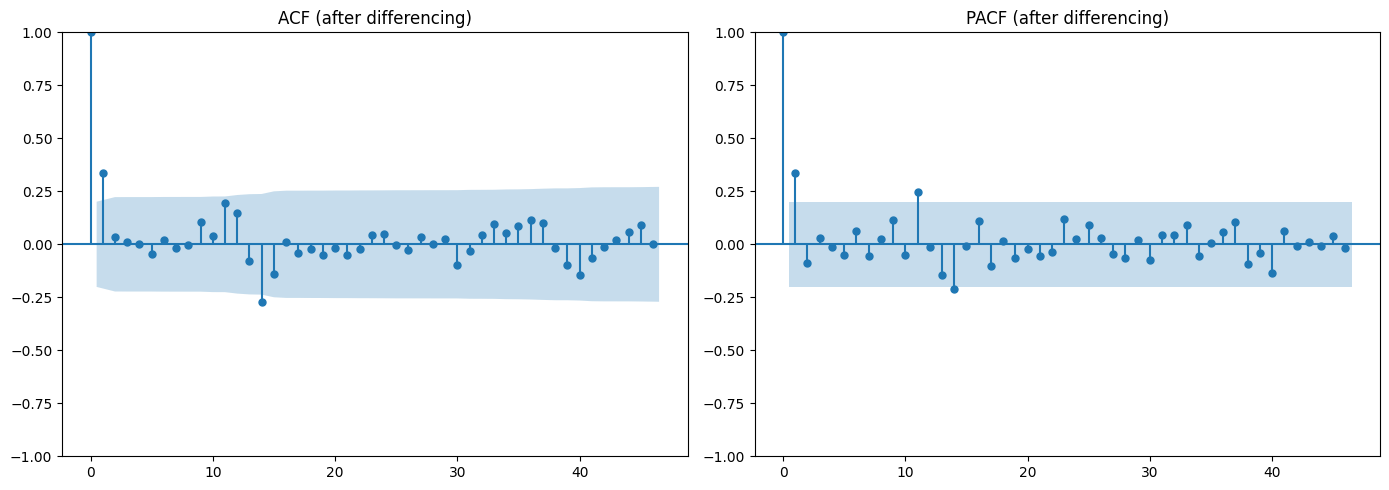

In [555]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

n = len(df["detrended"].dropna())

plot_acf(df["detrended"].dropna(), ax=axes[0], lags=n//2 - 1)
axes[0].set_title("ACF (after differencing)")

plot_pacf(df["detrended"].dropna(), ax=axes[1], lags=n//2 - 1, method="ywm")
axes[1].set_title("PACF (after differencing)")

plt.tight_layout()
plt.show()


The model with the lowest AIC is usually the best choice.

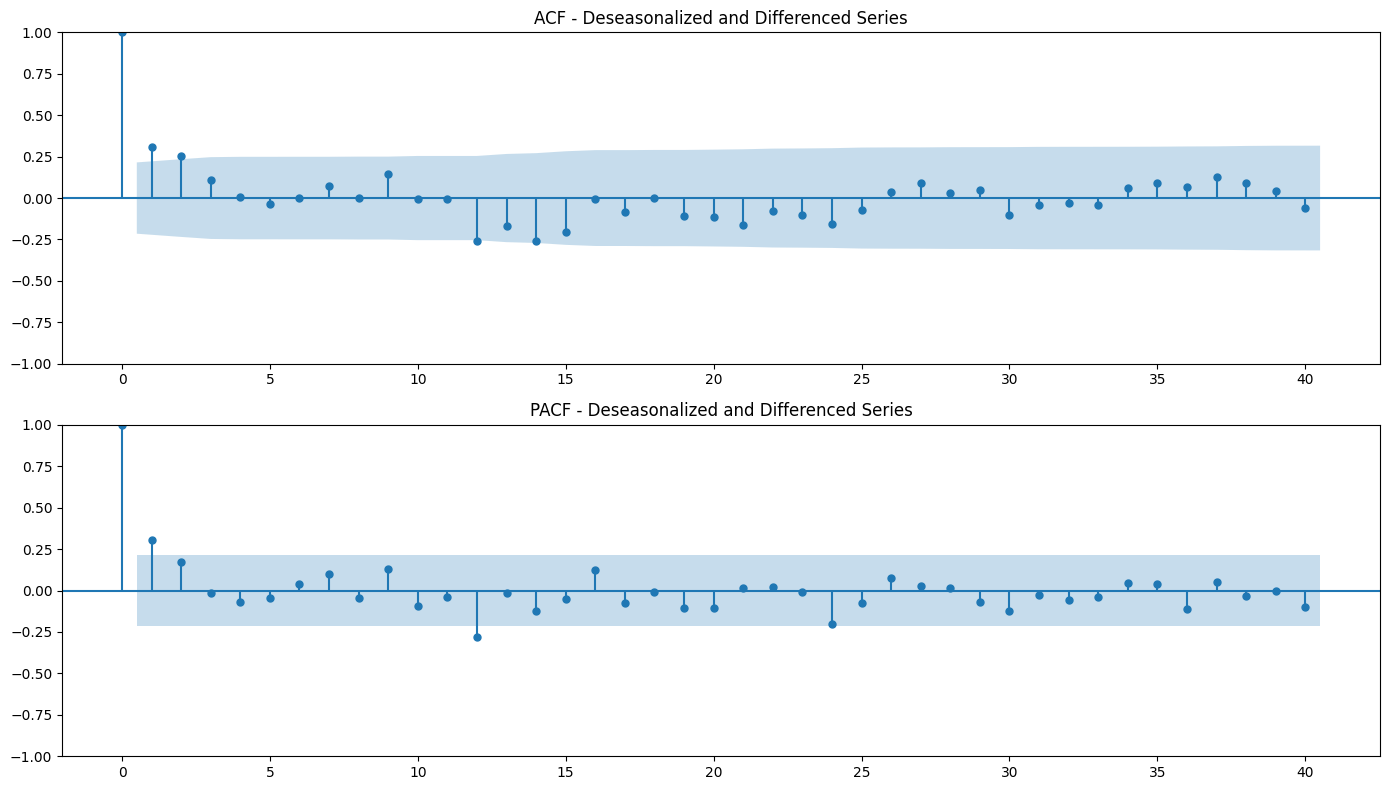

In [556]:
stl = STL(df['basket_price'], period=12)
res = stl.fit()

df['deseasonalized'] = df["basket_price"].diff(12)

df['deseasonalized_diff'] = df['deseasonalized'].diff()

diff_series = df['deseasonalized_diff'].dropna()

max_lags = min(40, len(diff_series) // 2)

fig, axes = plt.subplots(2, 1, figsize=(14, 8))
plot_acf(diff_series, ax=axes[0], lags=max_lags)
axes[0].set_title('ACF - Deseasonalized and Differenced Series')
plot_pacf(diff_series, ax=axes[1], lags=max_lags, method='ywm')
axes[1].set_title('PACF - Deseasonalized and Differenced Series')
plt.tight_layout()
plt.show()


In [557]:
df = df.set_index("Місяць")
model_a = ARIMA(df["basket_price"], order=(1, 1, 1)).fit()
print("ARIMA(1,1,1):", model_a.aic)

ARIMA(1,1,1): 949.0951295905317


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


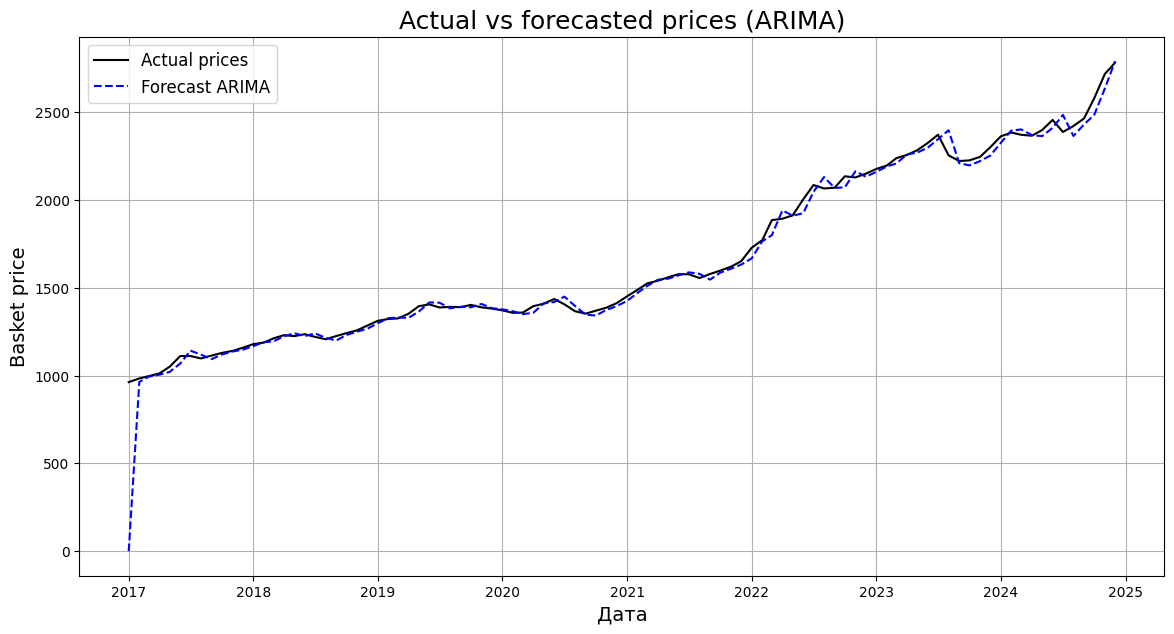

In [558]:
pred = model_a.predict(start=df.index[0], end=df.index[-1], typ="levels")

plt.figure(figsize=(14, 7))
plt.plot(df.index, df["basket_price"], label="Actual prices", color='black')
plt.plot(df.index, pred, label="Forecast ARIMA", color='blue', linestyle="--")
plt.title("Actual vs forecasted prices (ARIMA)", fontsize=18)
plt.xlabel("Дата", fontsize=14)
plt.ylabel("Basket price", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


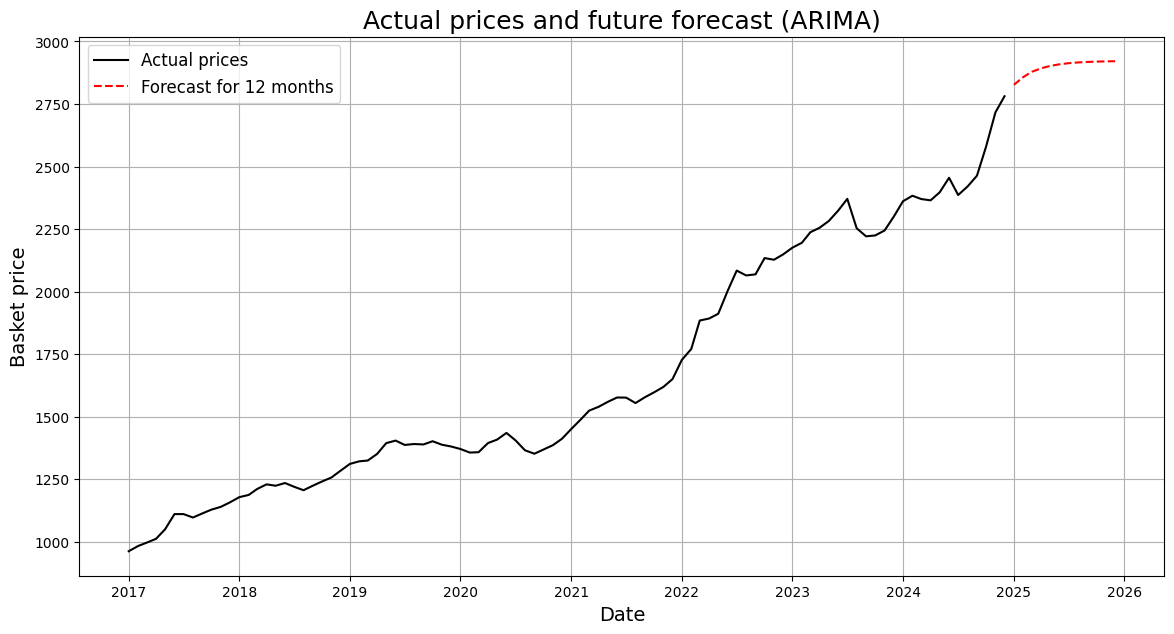

In [559]:
model_a = ARIMA(df["basket_price"], order=(1, 1, 1)).fit()

steps_ahead = 12

forecast = model_a.forecast(steps=steps_ahead)

last_date = df.index[-1]
forecast_index = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=steps_ahead, freq='MS')

forecast = pd.Series(forecast, index=forecast_index)

plt.figure(figsize=(14, 7))
plt.plot(df.index, df["basket_price"], label="Actual prices", color='black')
plt.plot(forecast.index, forecast, label="Forecast for 12 months", color='red', linestyle="--")
plt.title("Actual prices and future forecast (ARIMA)", fontsize=18)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Basket price", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [560]:
df.to_csv("all_data_final.csv")

In [561]:
df['pi'] = np.log(df['CPI']) - np.log(df['CPI'].shift(1))
df = df.dropna(subset=['pi'])

In [562]:
covid_pi = df.loc['2020-03-01':'2021-08-31', 'pi']
war_pi  = df.loc['2022-02-01':'2024-12-31', 'pi']

In [563]:
covid_df = pd.DataFrame({
    'pi':   covid_pi,
    'lag1': covid_pi.shift(1)
}).dropna()

war_df = pd.DataFrame({
    'pi':   war_pi,
    'lag1': war_pi.shift(1)
}).dropna()

covid_res = sm.OLS(covid_df['pi'], sm.add_constant(covid_df['lag1'])).fit()
war_res   = sm.OLS(war_df['pi'],   sm.add_constant(war_df['lag1'])).fit()
phi_c, se_c = covid_res.params['lag1'], covid_res.bse['lag1']
phi_w, se_w = war_res.params['lag1'],   war_res.bse['lag1']

In [564]:
Z = (phi_w - phi_c) / np.sqrt(se_w**2 + se_c**2)

p_value = norm.sf(Z)
print(f"COVID φ̂ = {phi_c:.3f}, SE = {se_c:.3f}")
print(f"War   φ̂ = {phi_w:.3f}, SE = {se_w:.3f}")
print(f"Z = {Z:.3f}")
print(f"One‐sided p‐value = {p_value:.3f}")

if p_value < 0.05:
    print("Reject H0 at 5% → war persistence is significantly higher.")
else:
    print("Fail to reject H0 at 5%, thus no evidence war persistence exceeds COVID persistence.")


COVID φ̂ = 0.562, SE = 0.229
War   φ̂ = 0.221, SE = 0.172
Z = -1.189
One‐sided p‐value = 0.883
Fail to reject H0 at 5%, thus no evidence war persistence exceeds COVID persistence.


In [565]:
h1_res = model.t_test('war - covid = 0')
print(h1_res.summary())

t_val      = h1_res.tvalue.item()
p_one_sided = h1_res.pvalue.item() / 2 if t_val > 0 else 1 - h1_res.pvalue.item() / 2
print(f'\nOne-sided p-value (war > covid): {p_one_sided:0.4f}')

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            30.3494      4.689      6.473      0.000      21.015      39.684

One-sided p-value (war > covid): 0.0000


In [566]:
h2_res = model.f_test('unemployed = 0, salary = 0, надходження = 0')
print(h2_res.summary())

<F test: F=4.246259225289202, p=0.007828176763731643, df_denom=78, df_num=3>
